### Importing all the relevant libraries

In [214]:
import matplotlib
import matplotlib.pyplot as plt
import pkg_resources
import pandas as pd
import numpy as np
import sobol_seq
from tabulate import tabulate
import types

In [223]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tabulate==0.8.3
pandas==0.24.2
numpy==1.16.2
matplotlib==3.0.3


### Define a function to uniform the database formatting as to ease their cross-comparison

In [ ]:
def formatting(x):
    return pd.pivot_table(pd.melt(x,id_vars=['ProgrammingPeriod','Country','NUTS1Code','NUTS2Code','Year'],
        var_name='FundingScheme'),index=['ProgrammingPeriod','FundingScheme','Country','NUTS1Code','NUTS2Code'],
        values='value',columns='Year')

### Open the dataset and isolate the rows relative to DG REGIO programmes

In [ ]:
df = pd.read_excel('20181231 Pagamenti ammessi PO 2007-2013.xls',usecols=[0,1,2,3,4,5,7])
df_EU = pd.read_excel('Database_Final_UPD(3).xlsx')
df_REGIO = df[(df['CCI'].str.contains("161"))|df['CCI'].str.contains("162")]
df_expenditures = pd.read_excel('PivotedData.xlsx',sheet_name='Mean',index_col=0)

### Check for any potential pattern as regards negative payments

In [222]:
df_negative = df_REGIO[df_REGIO.PAGAMENTO_AMMESSO_UE<0]

df_negative_count = pd.DataFrame([[idn[1],idn[0],len(dn)] for idn, dn in 
df_negative.groupby(['COD_TEMA_PRIORITARIO_UE','DESCR_TEMA_PRIORITARIO_UE'])],
columns=['DESCR_TEMA_PRIORITARIO_UE','COD_TEMA_PRIORITARIO_UE','count']).sort_values(by='count',ascending=False)
df_negative_count.head(10)
print(tabulate(df_negative_count.head(10),showindex=False,headers='keys'))

DESCR_TEMA_PRIORITARIO_UE                                                                                    COD_TEMA_PRIORITARIO_UE    count
---------------------------------------------------------------------------------------------------------  -------------------------  -------
Altre misure per stimolare la ricerca, l'innovazione e l'imprenditorialità nelle PMI                                              09       23
Investimenti nelle imprese direttamente connesse alla ricerca e all'innovazione (...)                                             07       17
Efficienza dell'energia, cogenerazione, gestione dell'energia                                                                     43       16
Altra assistenza per migliorare i servizi turistici                                                                               57       13
Preparazione, attuazione, monitoraggio e ispezione                                                                                85       13
Energi

### Let us normalise the database as to make figures consistent between the Italian and the EU datasets

In [ ]:
df_REGIO_capped = df_REGIO[df_REGIO.ANNO<2017]

### Let adjust the database formatting for the sake of comparability across figures

In [ ]:
DS = [df_EU,df_expenditures]
ds_names = ['EU_Payments','Expenditures']
ds_pivoted = dict(zip(ds_names,[formatting(ds) for ds in DS]))

### Let isolate the IT figures for the programming period 2007-2013, the funding scheme ERDF

In [ ]:
df_ERDF_20172013_IT=ds_pivoted['Expenditures'].loc['2007-2013','ERDF_TOTAL','IT',:,:]
Excess = -df_ERDF_20172013_IT.sum().sum()+df_REGIO_capped.PAGAMENTO_AMMESSO_UE.sum()
Excess

In [ ]:
df_REGIO_yearly = df_REGIO_capped.groupby('ANNO')
df_REGIO_sum = pd.DataFrame([dfr.PAGAMENTO_AMMESSO_UE.sum() for idf, dfr in df_REGIO_yearly], 
                            index=[idf for idf, dfr in df_REGIO_yearly],columns=['sum'])

### Let us test how the assumption on the number of years from which the exceeding payment should be cut out for the sake of normalisation

The cumulative distance is 0.58


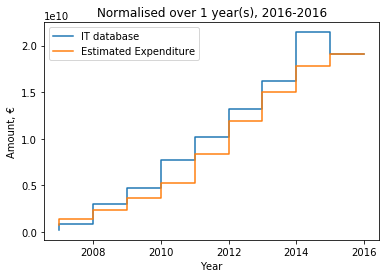

The cumulative distance is 0.43


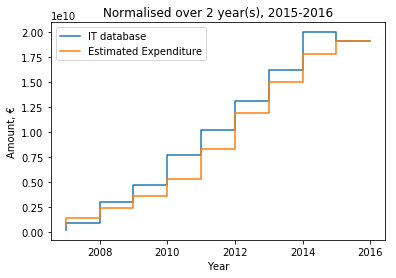

The cumulative distance is 0.48


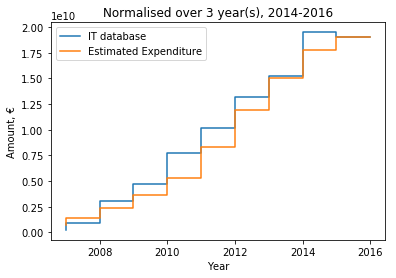

The cumulative distance is 0.5


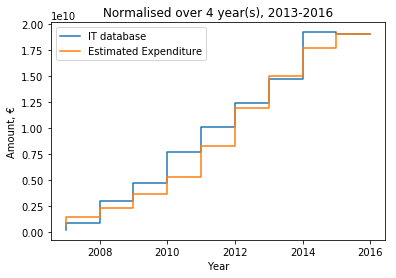

The cumulative distance is 0.52


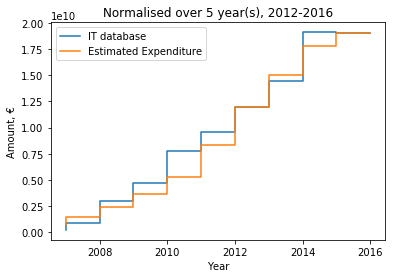

The cumulative distance is 0.48


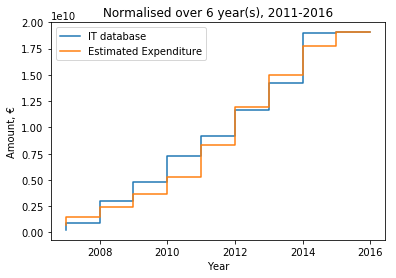

The cumulative distance is 0.45


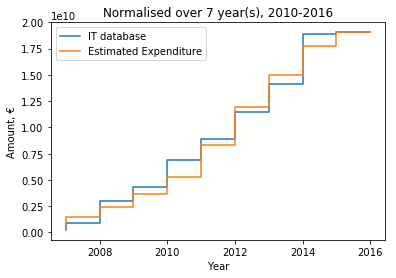

The cumulative distance is 0.43


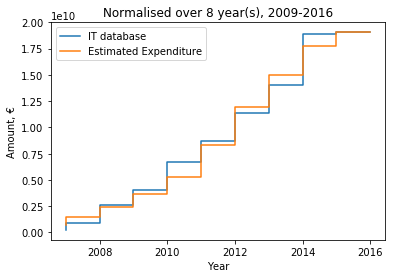

The cumulative distance is 0.44


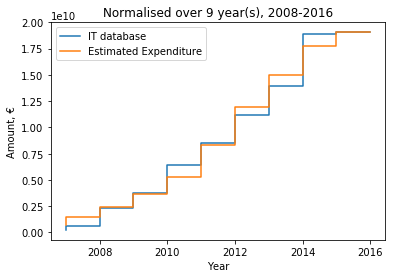

The cumulative distance is 0.46


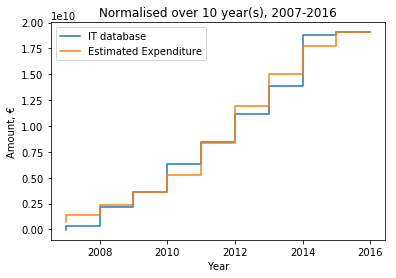

In [213]:
for i in reversed(df_REGIO_sum.index):
    df_REGIO_norm = df_REGIO_sum.copy()
    df_REGIO_norm.loc[i:2016]=df_REGIO_sum.loc[i:2016]-Excess/(2016-i+1)
    print('The cumulative distance is ' + str((abs(df_REGIO_norm.values[:,0]-df_ERDF_20172013_IT.T.loc[2007:].T.sum().values).sum()/
          df_REGIO_norm.values[:,0].sum()).round(2)))
    plt.step(df_REGIO_sum.index,df_REGIO_norm.expanding(1).sum(),label='IT database')
    plt.step(df_REGIO_sum.index,df_ERDF_20172013_IT.T.loc[2007:].T.sum().expanding(1).sum(),label='Estimated Expenditure')
    plt.xlabel('Year')
    plt.ylabel('Amount, €')
    plt.title('Normalised over '+str(2016-i+1)+' year(s), '+str(i)+'-2016')
    plt.legend()
    plt.legend()
    plt.show()